## 1. Installation and imports

In [ ]:
!pip install onedrivedownloader nibabel
!pip install seg-metrics
!pip install MedPy
!pip install SimpleITK

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.7/228.7 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.7/512.7 kB 30.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.6/198.6 kB 20.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7029 sha256=46943df33ccca49c4ec75e5358f100a2702b15a36171a6f6a336f020009c144d
  Stored in directory: /root/.cache/pip/wheels/3d/fe/b0/27a9892da57472e538c7452a721a9cf463cc03cf7379889266
Successfully built littleutils
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [66]:
import importlib
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import medpy.metric.binary as mdp
import numpy as np
import os
import seg_metrics.seg_metrics as sg

from scipy.ndimage import distance_transform_edt, binary_erosion, generate_binary_structure
from scipy.ndimage import _ni_support

# Custom modules
# Note: all modules need to be reloaded inside running jupyter notebooks to recognize live updates
import utils.mri_images as mri
import utils.mri_plotter as mrp

_ = importlib.reload(mri)
_ = importlib.reload(mrp)

In [58]:
# change working directory
# NOTE: this path will probably differ for each person 
# option 1: either make everyone create the same folder path so this does not need to be changed everytime where running a notebook
# option 2: create a local environment file .env file to store individual configurations for each person (this will be in the .gitignore)
working_dir = '/content/drive/My Drive/Capstone Project/BioCV_Su23/src'
os.chdir(working_dir)

# download the images
nifi_img = mri.NiftiImage()
images = nifi_img.download(segm=True, auto_segm=True)


  0%|          | 0.00/10.3M [00:00<?, ?iB/s]
  9%|▉         | 929k/10.3M [00:00<00:01, 4.88MiB/s]
 27%|██▋       | 2.76M/10.3M [00:00<00:00, 9.38MiB/s]
100%|██████████| 10.3M/10.3M [00:00<00:00, 18.7MiB/s]


Unzipping file...



Extracting files: 100%|██████████| 611/611 [00:05<00:00, 116.30it/s]


Unzipping file...



Extracting files: 100%|██████████| 147/147 [00:00<00:00, 5554.47it/s]


In [62]:
# Get segmented and auto segmented files
segm_files = images[mri.SEGMENTED]
auto_segm_files = images[mri.AUTOSEGMENTED]

print("No. of segmented files:", len(segm_files))
print("No. of auto-segmented files:", len(auto_segm_files))

No. of segmented files: 147
No. of auto-segmented files: 611


### Data Functions

In [ ]:
# Source Code: https://github.com/loli/medpy/blob/master/medpy/metric/binary.py#L357
def calc_surface_distances(pred_img_bin, true_img_bin, voxelspacing=None, connectivity=1):
  """
  The distances between the surface voxel of binary objects in result and their
  nearest partner surface voxel of a binary object in reference.
  """
  if voxelspacing is not None:
      # ensures that the sequence has the same length as the number of dimensions in the result array
      # not needed for now
      voxelspacing = _ni_support._normalize_sequence(voxelspacing, pred_img_bin.ndim)
      voxelspacing = np.asarray(voxelspacing, dtype=np.float64)
      if not voxelspacing.flags.contiguous:
          voxelspacing = voxelspacing.copy()
          
  # this will create 3x3 binary array with False values at the center
  # and its surrounding structures. diagonals are not considered if connectivity = 1
  footprint = generate_binary_structure(pred_img_bin.ndim, connectivity)

  # extract only 1-pixel border line of objects
  # applies binary erosion to the image
  pred_img_border = pred_img_bin ^ binary_erosion(pred_img_bin, structure=footprint, iterations=1)
  true_img_border = true_img_bin ^ binary_erosion(true_img_bin, structure=footprint, iterations=1)

  # calculate distances from each voxel to the closest border 
  dist = distance_transform_edt(~true_img_border, sampling=voxelspacing)
  surface_dist = np.where(pred_img_border, dist, None)
  return surface_dist

def exec_hausdorff_95(pred_img, true_img, segment, plot=False):
  # convert image to binary
  true_img_bin = (true_img == segment)
  pred_img_bin = (pred_img == segment)

  if np.sum(true_img_bin) + np.sum(pred_img_bin) == 0:
    raise Exception("Images do not have common segments")

  connectivity = pred_img_bin.ndim * 2
  sd1 = calc_surface_distances(pred_img_bin, true_img_bin, connectivity=connectivity)
  sd2 = calc_surface_distances(true_img_bin, pred_img_bin, connectivity=connectivity)
  sd1_no_none = sd1[sd1 != None]
  sd2_no_none = sd2[sd2 != None]
  hd95_val = np.percentile(np.hstack((sd1_no_none, sd2_no_none)), 95)
  
  if plot:
    return [hd95_val, sd1, sd2]
  else:
    return hd95_val
  
def calc_hausdorff_95(pred_img, true_img, segment):
    return exec_hausdorff_95(pred_img, true_img, segment, plot=False)

def plot_hausdorff_95(pred_img, true_img, segment):
    return exec_hausdorff_95(pred_img, true_img, segment, plot=True)

def calc_dice_score(pred_img, true_img, segment):
    # metric in medical image segmentation to evaluate similarity or overlap between segmented images
    # convert images to binary
    true_img_bin = (true_img == segment)
    pred_img_bin = (pred_img == segment)

    # perform element wise multiplication to get intersection
    intersection = np.sum(pred_img_bin * true_img_bin)
    dice_score = (2.0 * intersection) / (np.sum(true_img_bin) + np.sum(pred_img_bin))
    return dice_score

def calc_metric_all_segments(segments, metric_func, *args, **kwargs):
    values = Parallel(n_jobs=-1)(delayed(metric_func)(*args, **kwargs, segment=segment) for segment in segments)
    return np.array(values)

### Metrics

In [ ]:
all_dice = []
all_hd95 = []
all_mislabelled = []
error_files = []

# Calculate dice score one by one for each image to avoid out-of-memory issues
subj_files = [segm_file.split("_segm")[0] for segm_file in segm_files]
for subj_file in subj_files:

  # load the segmented and auto segmented image of a file
  segm_img = nifi_img.read(subj_file, segm=True)[1]
  auto_segm_img = nifi_img.read(subj_file, auto_segm=True)[1]

  try:
      print(f"Calculating metrics for {subj_file}")
      # metric 1: just count incorrect labels for each file
      mislabelled_counts = [] 
      for segment in mri.SEGMENTS:
        mislabelled_count = np.count_nonzero((segm_img == segment) & (auto_segm_img != segment))
        mislabelled_counts.append(mislabelled_count)

      # metric 2: dice coefficient
      dice_score = calc_metric_all_segments(mri.SEGMENTS, calc_dice_score, auto_segm_img, segm_img)

      # metric 3: 95% Hausdorff
      hausdorff_val =  calc_metric_all_segments(mri.SEGMENTS, calc_hausdorff_95, auto_segm_img, segm_img)
  
      # append only when there is no error:
      all_mislabelled.append(mislabelled_counts)
      all_dice.append(dice_score)
      all_hd95.append(hausdorff_val)
  except Exception as ex:
      print(f"Error {subj_file}", ex)
      error_files.append(subj_file)

Calculating metrics for UPENN-GBM-00002_11
Calculating metrics for UPENN-GBM-00006_11
Calculating metrics for UPENN-GBM-00008_11
Calculating metrics for UPENN-GBM-00009_11
Calculating metrics for UPENN-GBM-00011_11
Calculating metrics for UPENN-GBM-00013_11
Calculating metrics for UPENN-GBM-00014_11
Calculating metrics for UPENN-GBM-00016_11
Calculating metrics for UPENN-GBM-00017_11
Calculating metrics for UPENN-GBM-00018_11
Calculating metrics for UPENN-GBM-00020_11
Calculating metrics for UPENN-GBM-00021_11
Calculating metrics for UPENN-GBM-00026_11
Calculating metrics for UPENN-GBM-00029_11
Calculating metrics for UPENN-GBM-00030_11
Calculating metrics for UPENN-GBM-00031_11
Calculating metrics for UPENN-GBM-00033_11
Calculating metrics for UPENN-GBM-00035_11
Calculating metrics for UPENN-GBM-00040_11
Calculating metrics for UPENN-GBM-00041_11
Calculating metrics for UPENN-GBM-00043_11
Calculating metrics for UPENN-GBM-00054_11
Calculating metrics for UPENN-GBM-00059_11
Calculating

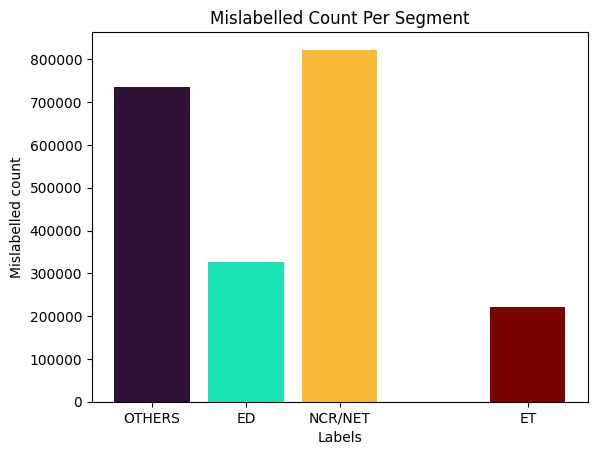

In [ ]:
# Plot mislabelled counts
cmap = plt.get_cmap('turbo')
colors = cmap(np.linspace(0, 1, len(mri.SEGMENTS)))

mislabelled_counts = np.array(all_mislabelled).sum(axis = 0)
plt.bar(mri.SEGMENTS, mislabelled_counts, color=colors)
plt.xlabel('Labels')
plt.ylabel('Mislabelled count')
plt.title('Mislabelled Count Per Segment')
plt.xticks(mri.SEGMENTS, mri.SEGMENT_NAMES)
plt.show()

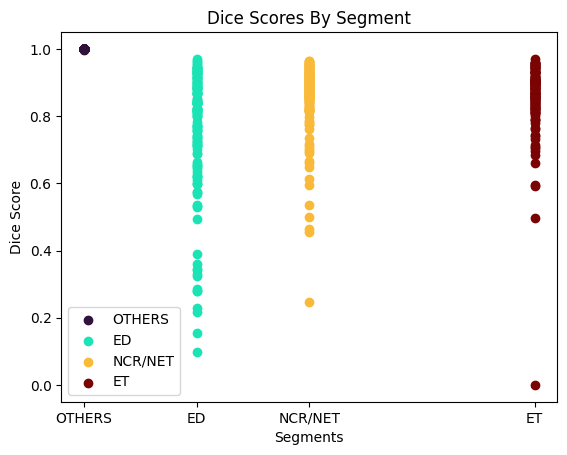

In [ ]:
# Plot the dice scores as a scatter plot
cmap = plt.get_cmap('turbo')
colors = cmap(np.linspace(0, 1, len(mri.SEGMENTS)))

for idx in range(len(mri.SEGMENTS)):
  dice_scores = np.array(all_dice)[:, idx]
  label = mri.SEGMENTS[idx]
  x_val = [label] * len(dice_scores)

  plt.scatter(x_val, dice_scores, label=f"{mri.SEGMENT_NAMES[idx]}", color=colors[idx])
  plt.xlabel('Segments')
  plt.ylabel('Dice Score')
  plt.title('Dice Scores By Segment')
  plt.legend()

plt.xticks(mri.SEGMENTS, mri.SEGMENT_NAMES)
plt.show()

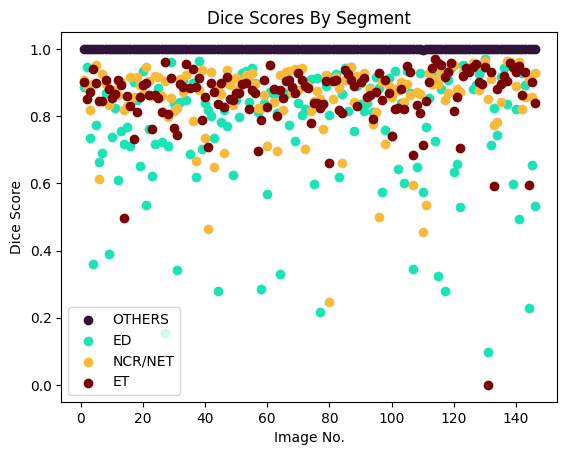

In [ ]:
cmap = plt.get_cmap('turbo')
colors = cmap(np.linspace(0, 1, len(mri.SEGMENTS)))

scores_len = len(all_dice)

for segm_idx in range(len(mri.SEGMENTS)):
  dice_scores = np.array(all_dice)[:, segm_idx]
  plt.scatter(np.arange(1, scores_len+1), dice_scores, color=colors[segm_idx], label=f"{mri.SEGMENT_NAMES[segm_idx]}")

plt.xlabel('Image No.')
plt.ylabel('Dice Score')
plt.title('Dice Scores By Segment')
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.legend()
plt.show()

In [ ]:
# Get 10 images with lowest dice scores
all_dice_np = np.array(all_dice)

# Flatten the array
flattened_array = all_dice_np.flatten()

# Find the indices of the top 10 smallest numbers
top_10_idx_1d = np.argpartition(flattened_array, kth=10)[:10]

# Reshape the indices back to the original 2D shape
top_10_indices = np.unravel_index(top_10_idx_1d, all_dice_np.shape)

# remove error files from subj_files
print("errors", error_files)
subj_files = list(filter(lambda x: x not in error_files, subj_files))
print(f"New length after removing problematic images: {len(subj_files)}")

subj_files_np = np.array(subj_files)
lowest_dice_images = subj_files_np[list(top_10_indices[0])]

(array([130,  26, 130,  76,  79,  43, 143,  57, 116, 114]),
 array([3, 1, 1, 1, 2, 1, 1, 1, 1, 1]))

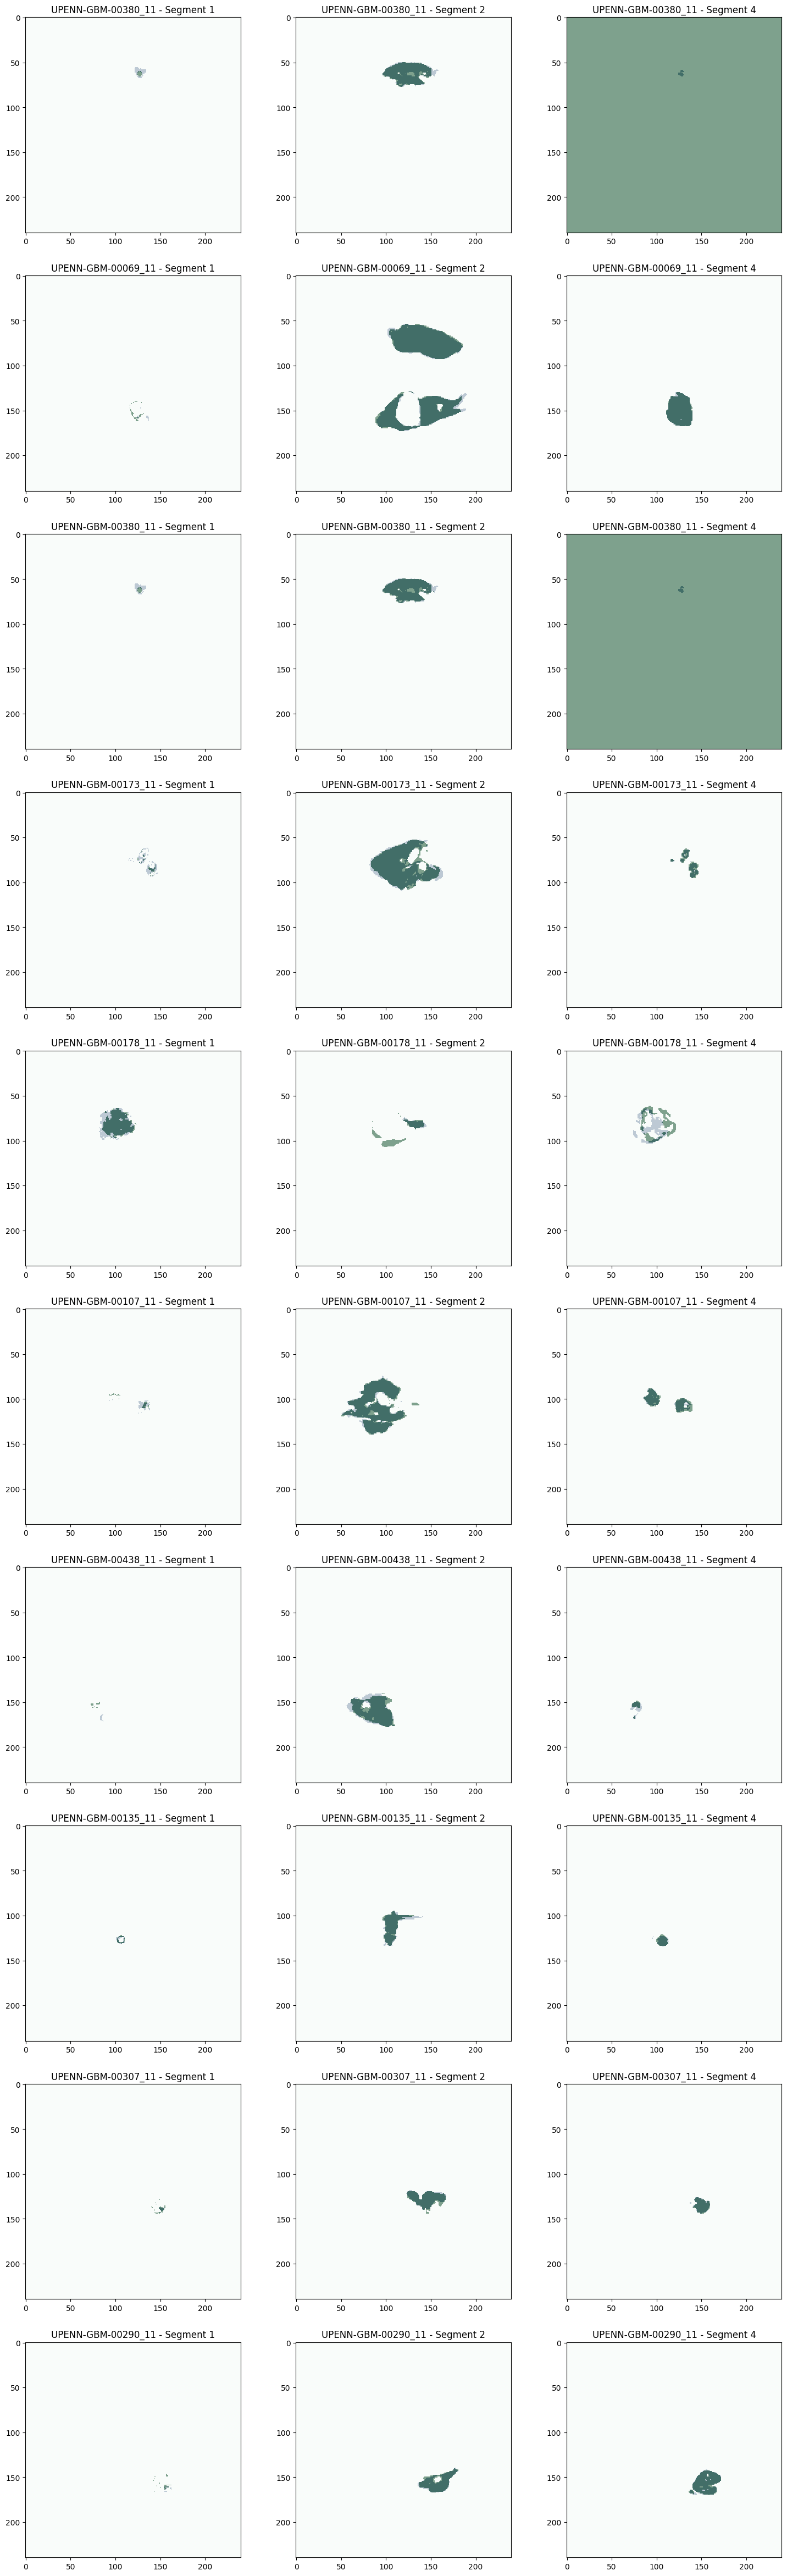

In [84]:
_ = importlib.reload(mrp)
mri_plt = mrp.MRIPlotter()
nrows=10
ncols=3
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6*ncols, 6*nrows))

row, col = 0, 0
for subj_file in lowest_dice_images:
  true_img_name, true_img = nifi_img.read(subj_file=subj_file, segm=True)
  pred_img_name, pred_img = nifi_img.read(subj_file=subj_file, auto_segm=True)
  
  for segment in mri.SEGMENTS[1:]:
    true_img_bin = (true_img == segment)
    pred_img_bin = (pred_img == segment)

    mri_plt.plot_segm_img(img_data=true_img_bin, fig=fig, axs=axs, row=row, col=col, 
                          title=f"{subj_file} - Segment {segment}", segm_cbar=False, cmap='Blues', alpha=0.5)
    mri_plt.plot_segm_img(img_data=pred_img_bin, fig=fig, axs=axs, row=row, col=col, 
                          title=f"{subj_file} - Segment {segment}", segm_cbar=False, cmap='Greens', alpha=0.5)

    col +=1
    if col%3 == 0 and col > 0:
      col = 0
      row += 1

plt.title("Top 10 images with Lowest Dice Scores")
plt.show()